n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     24 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      130 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0548706766 |         ideal
     3 |      160 |     29 |  0.000000E+00 |  0.000000E+00 |  0.0065092910 |         ideal
     4 |      190 |     38 |  0.000000E+00 |  0.000000E+00 |  0.0316847776 |         ideal
     5 |      220 |     48 |  0.000000E+00 |  0.000000E+00 |  0.0457003836 |         ideal
     6 |      250 |     60 |  0.000000E+00 |  0.000000E+00 |  0.0137524208 |         ideal
     7 |      280 |     59 |  0.000000E+00 |  0.000000E+00 |  0.0059090224 |         ideal
     8 |      310 |     60 |  0.000000E+00 |  0.000000E+00 |  0.6603528015 |         nadir
     9 |      340 |     71 |  0.000000E+00 |  0.000000E+00 |  0.0121192535 |             f
    10 |      370 |     83 |  0.000000E+00 |  0.000000E+00 |  0.0074246472 |             f

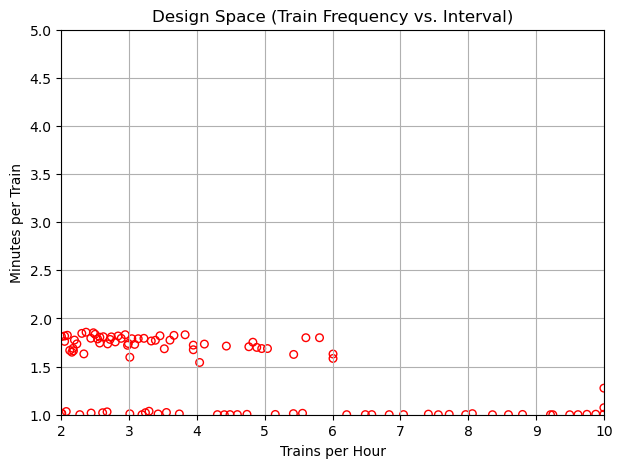

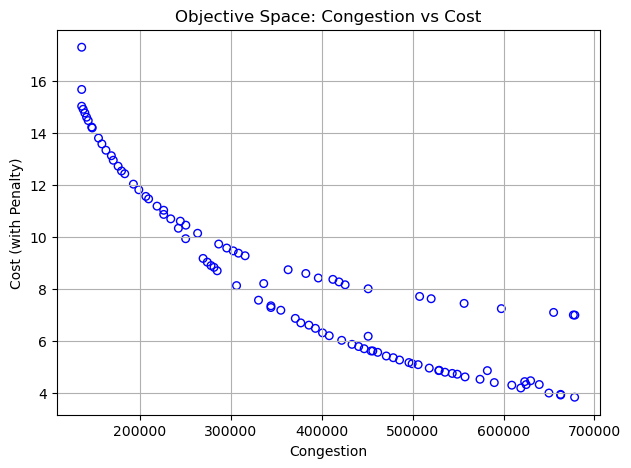

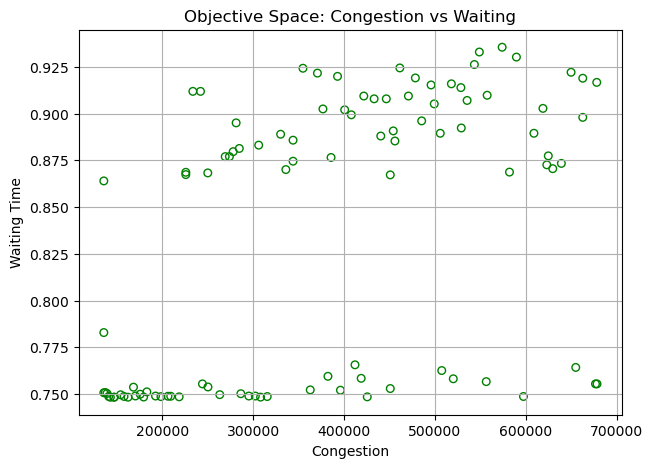

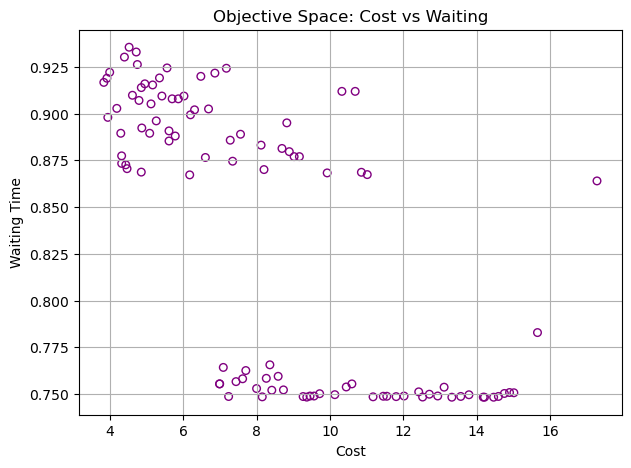

In [ ]:
import numpy as np
import pandas as pd
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize
import matplotlib.pyplot as plt

# === Read data ===
df = pd.read_csv("Final_MRT_Weather_Visitors_Holiday.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Only consider data for holidays
holiday_df = df[df['is_holiday'] == 1]
total_tap = holiday_df['tap_in'] + holiday_df['tap_out']
avg_tap = total_tap.mean()

# === Custom problem class ===
class MRTProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(
            n_var=2,
            n_obj=3,
            n_ieq_constr=1,
            xl=np.array([2, 1]),
            xu=np.array([10, 5])
        )

    def _evaluate(self, x, out, *args, **kwargs):
        freq, interval = x

        # Congestion
        congestion = (avg_tap * 1000) / (freq + 1e-6)

        # Cost (basic cost)
        base_cost = freq * interval

        # 💡 Smooth penalty term (the smaller the interval, the heavier the penalty)
        penalty = 5 / (1 + np.exp(10 * (interval - 1.5)))  # sigmoid transition

        cost = base_cost + penalty

        # Add a slight penalty to waiting time (reflects operational inefficiencies)
        waiting = interval / 2 + penalty * 0.05  # adjustable ratio

        # Operational constraint
        g1 = freq * interval - 60

        out["F"] = [congestion, cost, waiting]
        out["G"] = [g1]

# === Initialize the problem ===
problem = MRTProblem()

# === Initialize the algorithm ===
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=30,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

# === Termination condition ===
termination = get_termination("n_gen", 100)

# === Perform optimization ===
res = minimize(problem,
               algorithm,
               termination,
               seed=42,
               save_history=True,
               verbose=True)

# === Extract results ===
X = res.X
F = res.F

# === Visualize Design Space ===
xl, xu = problem.bounds()
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], s=30, facecolors='none', edgecolors='r')
plt.xlim(xl[0], xu[0])
plt.ylim(xl[1], xu[1])
plt.title("Design Space (Train Frequency vs. Interval)")
plt.xlabel("Trains per Hour")
plt.ylabel("Minutes per Train")
plt.grid(True)
plt.show()

# === Visualize Objective Space ===
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.xlabel("Congestion")
plt.ylabel("Cost (with Penalty)")
plt.title("Objective Space: Congestion vs Cost")
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 2], s=30, facecolors='none', edgecolors='green')
plt.xlabel("Congestion")
plt.ylabel("Waiting Time")
plt.title("Objective Space: Congestion vs Waiting")
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 5))
plt.scatter(F[:, 1], F[:, 2], s=30, facecolors='none', edgecolors='purple')
plt.xlabel("Cost")
plt.ylabel("Waiting Time")
plt.title("Objective Space: Cost vs Waiting")
plt.grid(True)
plt.show()


In [ ]:
best_idx = np.argmin(F[:, 0]) 
print(f"Best schedule: freq={X[best_idx, 0]:.2f}, interval={X[best_idx, 1]:.2f}")


Best schedule: freq=10.00, interval=1.28


In [ ]:
# Peak-hour scheduling scheme evaluation
freq = 10.0         # Number of trains per hour
interval = 1.28     # Interval for each train (minutes)

# Simulate the predicted number of inbound passengers each minute for one hour
total_passengers_per_hour = 5000
predicted_tap_in = np.full(60, total_passengers_per_hour / 60)

# Assume capacity per train
capacity_per_train = 800

# Build departure times for each train (in minutes)
train_schedule = np.arange(0, 60, interval)

# Initialize records
waiting_passengers = 0
total_wait_time = 0
total_served_passengers = 0
platform_wait_counts = []

# Simulate each minute
for t in range(60):
    # New inbound passengers
    new_passengers = predicted_tap_in[t]
    waiting_passengers += new_passengers

    # If there's a departure this minute
    if any(np.isclose(t, train_schedule, atol=0.5)):
        boarded = min(waiting_passengers, capacity_per_train)
        waiting_passengers -= boarded
        total_served_passengers += boarded

    # Record the number of people on the platform and the wait time
    platform_wait_counts.append(waiting_passengers)
    total_wait_time += waiting_passengers

# Compute metrics
max_congestion = np.max(platform_wait_counts)
avg_congestion = np.mean(platform_wait_counts)
avg_wait_time = total_wait_time / total_passengers_per_hour
wait_time = avg_wait_time * 10
utilization = (total_served_passengers / (freq * capacity_per_train)) * 100

# Print results
print("📊 Evaluation metrics for the optimal scheduling scheme at a normal station during peak hours:")
print(f"Maximum platform congestion: {max_congestion:.2f}")
print(f"Average platform congestion: {avg_congestion:.2f}")
print(f"Weighted average waiting time (minutes): {wait_time:.2f}")
print(f"Average capacity utilization: {utilization:.2f}%")


📊 Evaluation metrics for the optimal scheduling scheme at a normal station during peak hours:
Maximum platform congestion: 83.33
Average platform congestion: 18.06
Weighted average waiting time (minutes): 2.17
Average capacity utilization: 62.50%


In [31]:
# Peak-hour interchange station scheduling scheme
freq = 10.0         # Number of trains per hour
interval = 1.28     # Interval for each train (minutes)

# Simulate the predicted number of inbound passengers each minute for one hour
total_passengers_per_hour = 8000
predicted_tap_in = np.full(60, total_passengers_per_hour / 60)

# Assume capacity per train
capacity_per_train = 800

# Build departure times for each train (in minutes)
train_schedule = np.arange(0, 60, interval)

# Initialize records
waiting_passengers = 0
total_wait_time = 0
total_served_passengers = 0
platform_wait_counts = []

# Simulate each minute
for t in range(60):
    # New inbound passengers
    new_passengers = predicted_tap_in[t]
    waiting_passengers += new_passengers

    # If there's a departure this minute
    if any(np.isclose(t, train_schedule, atol=0.5)):
        boarded = min(waiting_passengers, capacity_per_train)
        waiting_passengers -= boarded
        total_served_passengers += boarded

    # Record the number of people on the platform and the wait time
    platform_wait_counts.append(waiting_passengers)
    total_wait_time += waiting_passengers

# Compute metrics
max_congestion = np.max(platform_wait_counts)
avg_congestion = np.mean(platform_wait_counts)
avg_wait_time = total_wait_time / total_passengers_per_hour
wait_time = avg_wait_time * 12.5
utilization = (total_served_passengers / (freq * capacity_per_train)) * 100

# Print results
print("📊 Evaluation metrics for the optimal scheduling scheme at an interchange station during peak hours:")
print(f"Maximum platform congestion: {max_congestion:.2f}")
print(f"Average platform congestion: {avg_congestion:.2f}")
print(f"Weighted average waiting time (minutes): {wait_time:.2f}")
print(f"Average capacity utilization: {utilization:.2f}%")


📊 Evaluation metrics for the optimal scheduling scheme at an interchange station during peak hours:
Maximum platform congestion: 133.33
Average platform congestion: 28.89
Weighted average waiting time (minutes): 2.71
Average capacity utilization: 100.00%
